# Modeling spike data with `multidms.jaxmodels`

In [1]:
import multidms
import multidms.jaxmodels

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy
import os

Papermill params

In [2]:
replicate = 1
truncate_nonsense = True
output_dir = 'output'

reference = 'Omicron_BA1'
l2reg = 1e-4
fusionreg = 2e0
block_iters = 100
block_tol = 1e-5

ge_tol = 1e-5
ge_maxiter = 500
ge_maxls = 30

cal_tol = 1e-5
cal_maxiter = 500
cal_maxls = 30

In [3]:
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

## Data loading/filtering

Read raw data, pick replicate 1, and aggregate counts

In [4]:
df = pd.read_csv("training_functional_scores_no_agg.csv", keep_default_na=False)

df.query(f"replicate == {replicate}", inplace=True)

df = df.groupby(["condition", "replicate", "aa_substitutions"]).agg(
    {"n_subs": "first", "pre_count": "sum", "post_count": "sum"}
    ).reset_index()

df

,condition,replicate,aa_substitutions,n_subs,pre_count,post_count
0,Delta,1,,0,5027212,4967837
1,Delta,1,A1015D,1,978,291
2,Delta,1,A1015D E1188Q,2,796,268
3,Delta,1,A1015D T1027S,2,841,63
4,Delta,1,A1015D T1117C V1176F,3,4,0
...,...,...,...,...,...,...
174469,Omicron_BA2,1,Y91N D138N Q474E,3,217,26
174470,Omicron_BA2,1,Y91N N603I S1252Y,3,792,160
174471,Omicron_BA2,1,Y91T N137T F375T F562L Q804H,5,627,13
174472,Omicron_BA2,1,Y91T S98T A845S L1193P,4,962,63


### Count filtering

Apply some thresholds to filter out low counts. We need pre-counts to be reasonably high to satisfy assumptions of the count-based loss function.

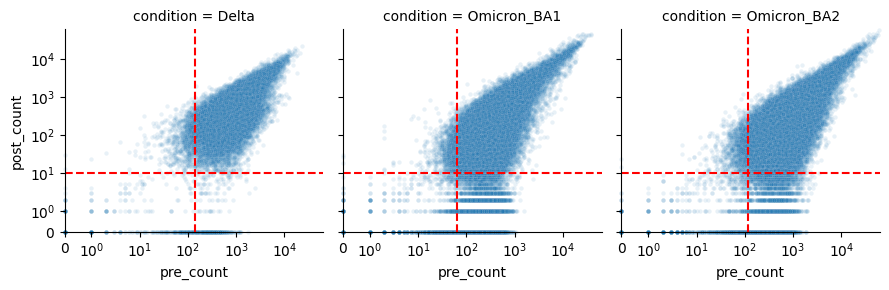

In [5]:
g = sns.relplot(
    x=df.pre_count[df.aa_substitutions != ""],
    y=df.post_count[df.aa_substitutions != ""],
    col=df.condition[df.aa_substitutions != ""],
    s=10, alpha=0.1,
    height=3, aspect=1,
    clip_on=False,
    )
plt.xlim(0, None)
plt.ylim(0, None)
plt.xscale("symlog", linthresh=1, linscale=0.5)
plt.yscale("symlog", linthresh=1, linscale=0.5)

for ax in g.axes.flat:
    condition = ax.get_title().split(" = ")[1]
    df_condition = df.query(f"(condition == @condition) & (aa_substitutions != '')")
    pre_thresh = np.percentile(df_condition.pre_count, 5)
    post_thresh = 10
    df.drop(index=df_condition.query("(pre_count < @pre_thresh) | (post_count < @post_thresh)").index, inplace=True)
    ax.axvline(pre_thresh, color="red", linestyle="--")
    ax.axhline(post_thresh, color="red", linestyle="--")

plt.tight_layout()
plt.show()

### Mutation number filtering

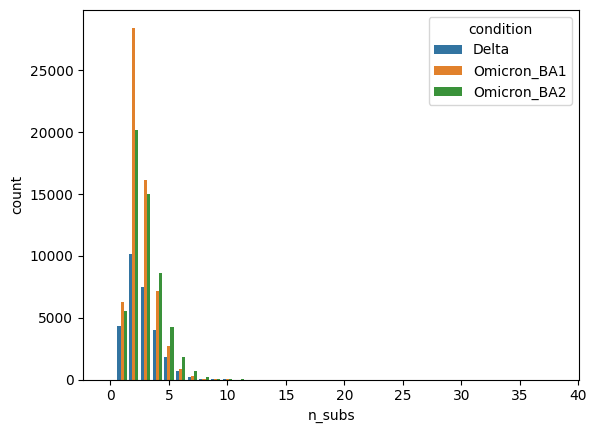

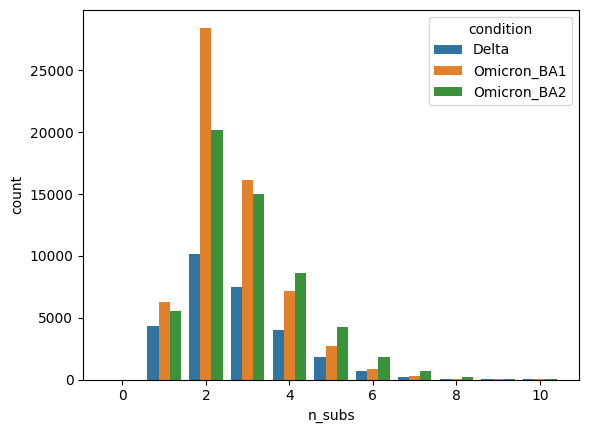

In [6]:
sns.countplot(data=df, x="n_subs", hue="condition", native_scale=True)
plt.show()

df = df.query("n_subs <= 10")

sns.countplot(data=df, x="n_subs", hue="condition", native_scale=True)
plt.show()


### Nonsense variants

Truncate nonsense variants to exlude any mutations downstream of the first nonsense mutation, and then filter to only nonsense variants with no missense mutation before first nonsense.

In [7]:
def truncate_nonsense(row):
    if row.aa_substitutions:
        muts = row.aa_substitutions.split(" ")
        assert len(muts) == row.n_subs, row
        new_muts = []
        for mut in muts:
            new_muts.append(mut)
            if "*" in mut:
                break
        row.aa_substitutions = " ".join(new_muts)
        row.n_subs = len(new_muts)
    return row

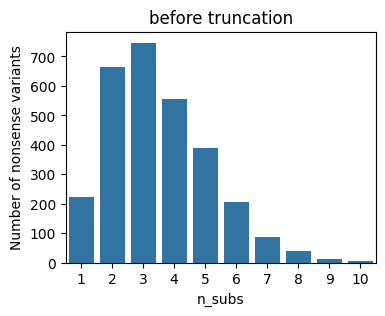

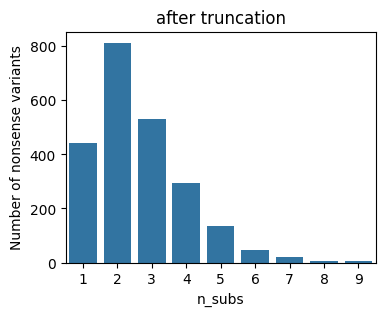

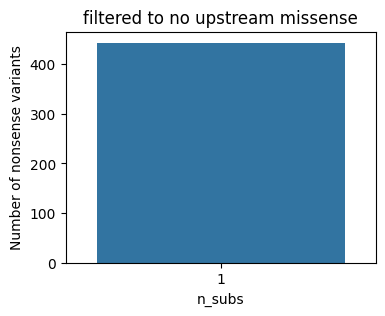

In [8]:
plt.figure(figsize=(4, 3))
sns.countplot(x=df.loc[df.aa_substitutions.str.contains("*", regex=False)].n_subs)
plt.ylabel("Number of nonsense variants")
plt.title("before truncation")
plt.show()

if truncate_nonsense:
    df = df.apply(truncate_nonsense, axis=1)
    # re-aggregate identical variants
    df = df.groupby(["condition", "replicate", "aa_substitutions"]).agg(
        {"n_subs": "first", "pre_count": "sum", "post_count": "sum"}
        ).reset_index()

    plt.figure(figsize=(4, 3))
    sns.countplot(x=df.loc[df.aa_substitutions.str.contains("*", regex=False)].n_subs)
    plt.ylabel("Number of nonsense variants")
    plt.title("after truncation")
    plt.show()

    df = df.loc[~(df.aa_substitutions.str.contains("*", regex=False) & (df.n_subs > 1)), :]

    plt.figure(figsize=(4, 3))
    sns.countplot(x=df.loc[df.aa_substitutions.str.contains("*", regex=False)].n_subs)
    plt.ylabel("Number of nonsense variants")
    plt.title("filtered to no upstream missense")
    plt.show()

### Compute functional scores

Note: $\log$ is more natural than $\log_2$ in the fitness-based model

In [9]:
pseudocount = 0.5
df["func_score"] = np.log(df["post_count"] + pseudocount) - np.log(df["pre_count"] + pseudocount)

def group_wt_ref(df_group):
    wts = df_group.query("aa_substitutions == ''")
    assert wts.shape[0] == 1, wts
    df_group.func_score = df_group.func_score.values - wts.func_score.values[0]
    return df_group

df = df.groupby(["condition", "replicate"]).apply(group_wt_ref, include_groups=False).reset_index(level=-1, drop=True).reset_index()

In [10]:
df.shape

(144803, 7)

### Multidms data

Load as a multidms dataset, choosing a reference condition.

In [11]:
multidms_data = multidms.Data(
    df,
    alphabet=multidms.AAS_WITHSTOP_WITHGAP,
    reference=reference,
)

Create a `jaxmodels.Data` object, containing the array data

In [12]:
data_sets = {
    d: multidms.jaxmodels.Data.from_multidms(multidms_data, d)
    for d in multidms_data.conditions
    }

# Display the reference condition data object
data_sets[multidms_data.reference]

Data(
  x_wt=i8[10335],
  pre_count_wt=i64[],
  post_count_wt=i64[],
  X=BCOO(int8[56752, 10335], nse=145189),
  pre_counts=i64[56752],
  post_counts=i64[56752],
  functional_scores=f64[56752]
)

Plot the sums of the binary encodings of the variants

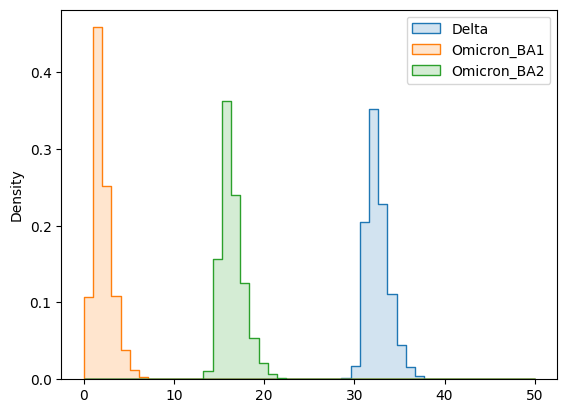

In [13]:
for d, data_set in data_sets.items():
    sns.histplot(x=data_set.X.sum(1, dtype=float).todense(), label=d, fill=True, alpha=0.2, element="step", bins=np.linspace(0, 50, 50), stat="density")
plt.legend()
plt.show()

Distribution of functional scores

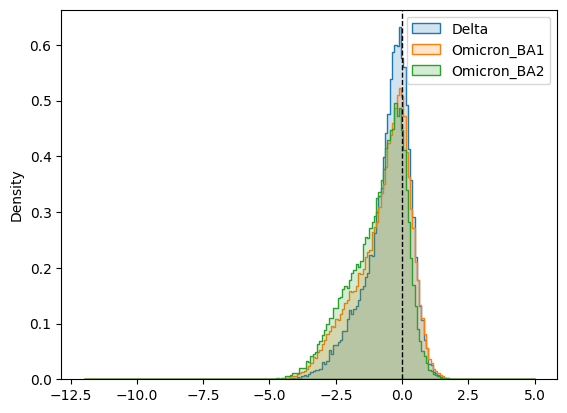

In [14]:
for d, data_set in data_sets.items():
    sns.histplot(x=data_set.functional_scores, label=d, fill=True, alpha=0.2, element="step", bins=np.linspace(-12, 5, 200), stat="density")
plt.axvline(0, color="black", linestyle="--", lw=1)
plt.legend()
plt.show()

## Fit model

In [15]:
# import jax.numpy as jnp
# import equinox as eqx
# import jaxopt
# import jax

# model = multidms.jaxmodels.Model(
#     φ={d: multidms.jaxmodels.Latent.warmstart(data_sets[d], l2reg=l2reg) for d in data_sets},
#     logα={d: jnp.array(0.0) for d in data_sets},
#     logθ={d: jnp.array(0.0) for d in data_sets},
#     reference_condition=multidms_data.reference,
# )

# @jax.jit
# def _objective_part(model_part, model_rest, data_sets):
#     model = eqx.combine(model_part, model_rest)
#     loss = sum(model.loss(data_sets).values())
#     n = sum(data_set.X.shape[0] for data_set in data_sets.values())
#     return loss / n

# opt_calibration = jaxopt.GradientDescent(_objective_part, verbose=True)

# filter_spec_calibration = multidms.jaxmodels.Model(
#     φ=False, logα=True, logθ=True, reference_condition=multidms_data.reference
#     )

# model_calibration, model_rest = eqx.partition(model, filter_spec_calibration)

# model_calibration, state = opt_calibration.run(model_calibration, model_rest, data_sets)
# state

In [16]:
# data_sets["Delta"].X[:, np.arange(0, 10)].sum(1).todense() != 0

# data_sets["Delta"]._filter((200, 300))

In [17]:
model = multidms.jaxmodels.fit(
    data_sets,
    multidms_data.reference,
    l2reg=l2reg,
    fusionreg=fusionreg,
    block_iters=block_iters,
    block_tol=block_tol,
    ge_kwargs=dict(
        tol=ge_tol,
        maxiter=ge_maxiter,
        maxls=ge_maxls,
        jit=True,
        # verbose=False
        ),
    cal_kwargs=dict(
        tol=cal_tol,
        maxiter=cal_maxiter,
        maxls=cal_maxls,
        jit=True,
        # verbose=False
        ),
    )

iter 1:
  calibration block: error=3.91e-06, γ=2.6e+02, iter=44
    Delta: α=4.48, θ=0.25
    Omicron_BA1: α=5.05, θ=0.31
    Omicron_BA2: α=5.32, θ=0.31
  β0 block: error=9.70e-06, γ=1.3e+02, iter=30
    Delta: β0=1.60
    Omicron_BA1: β0=-0.02
    Omicron_BA2: β0=-0.87
  β_bundle: error=2.05e-04, γ=8.0e+00, iter=500
  β_nonbundle: error=3.35e-05, γ=4.1e+03, iter=500
  Delta sparsity=0.452
  Omicron_BA2 sparsity=0.372
  objective_error=8.11e-02
iter 2:
  calibration block: error=6.78e-06, γ=1.3e+02, iter=19
    Delta: α=4.42, θ=0.24
    Omicron_BA1: α=5.08, θ=0.28
    Omicron_BA2: α=5.23, θ=0.29
  β0 block: error=8.44e-06, γ=6.4e+01, iter=13
    Delta: β0=1.45
    Omicron_BA1: β0=0.01
    Omicron_BA2: β0=-0.89
  β_bundle: error=2.95e-04, γ=4.0e+00, iter=500
  β_nonbundle: error=5.42e-05, γ=2.0e+03, iter=500
  Delta sparsity=0.441
  Omicron_BA2 sparsity=0.372
  objective_error=6.47e-04
iter 3:
  calibration block: error=4.75e-06, γ=1.3e+02, iter=17
    Delta: α=4.36, θ=0.24
    Omicron

$\beta$ shift distributions

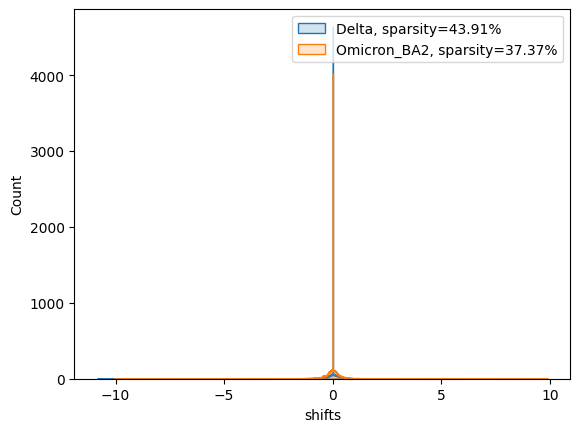

In [18]:
for d in data_sets:
    if d != model.reference_condition:
        shifts = model.φ[d].β - model.φ[model.reference_condition].β
        sns.histplot(
            x=shifts,
            label=f"{d}, sparsity={(shifts == 0).sum() / len(shifts):.2%}", fill=True, alpha=0.2, element="step")
plt.legend()
plt.xlabel("shifts")
plt.show()

Functional score correlations

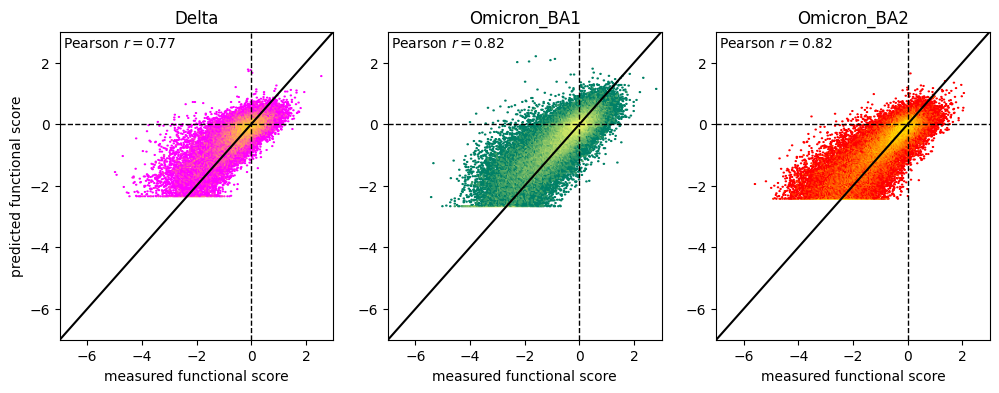

In [19]:
y_preds = model.predict_score(data_sets)

plt.figure(figsize=(12, 4))
ax = None
cmaps = ["spring", "summer", "autumn"]
colors = ["magenta", "green", "red"]
for i, (d, data_set) in enumerate(data_sets.items()):

    X = data_set.X
    x_wt = data_set.x_wt
    y = data_set.functional_scores
    y_pred = y_preds[d]

    ax = plt.subplot(1, 3, i + 1, sharex=ax, sharey=ax)
    plt.hexbin(y, y_pred, cmap=cmaps[i], gridsize=200, bins="log")
    # plt.scatter(y, y_pred, c=colors[i], s=0.1, alpha=0.5)
    plt.annotate(f"Pearson $r={scipy.stats.pearsonr(y, y_pred).statistic:.2f}$",
                 fontsize=10,
                 xy=(0.01, 0.95), xycoords="axes fraction")
    plt.plot([-10, 4], [-10, 4], "k")
    plt.axhline(0, color="k", linestyle="--", lw=1)
    plt.axvline(0, color="k", linestyle="--", lw=1)
    plt.xlim(-7, 3)
    plt.ylim(-7, 3)
    plt.xlabel("measured functional score")
    if i == 0:
        plt.ylabel("predicted functional score")
    plt.title(d)

plt.show()

Fitness landscape

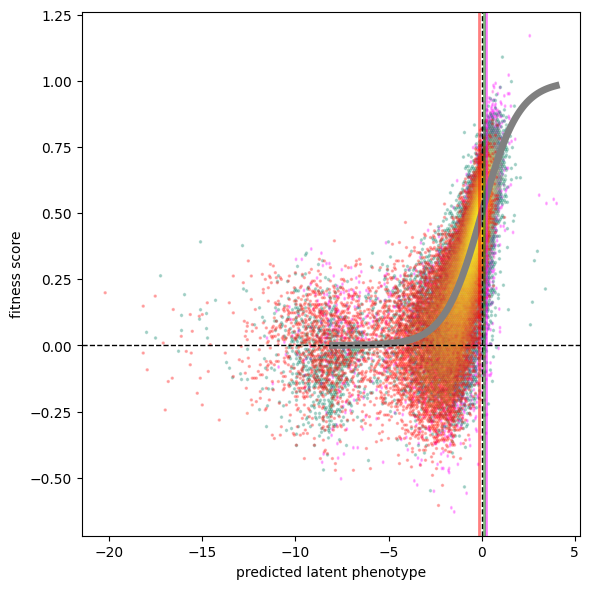

In [20]:
plt.figure(figsize=(6, 6))
φ_grid = np.linspace(-8, 4, 100)
plt.plot(φ_grid, model.g(φ_grid), "grey", lw=5, label=r"$g(\phi)$")
for i, (d, data_set) in enumerate(data_sets.items()):
    X = data_set.X
    x_wt = data_set.x_wt
    φ = model.φ[d]
    α = model.α[d]
    φ_pred = φ(X)
    φ_pred_wt = φ(x_wt)
    y = data_set.functional_scores
    f = y / α + model.g(φ(x_wt))
    # plt.scatter(φ_pred, f, color=colors[i], s=0.1, alpha=0.5)
    plt.hexbin(φ_pred, f, cmap=cmaps[i], bins="log", gridsize=200, alpha=0.25)
    plt.axvline(φ_pred_wt, color=colors[i], lw=2, alpha=0.5)
# plt.xlim(φ_grid[0], φ_grid[-1])
# plt.ylim(-12, 3)
plt.axhline(0, color="k", linestyle="--", lw=1)
plt.axvline(0, color="k", linestyle="--", lw=1)
plt.xlabel("predicted latent phenotype")
plt.ylabel("fitness score")
plt.tight_layout()
plt.show()

Joint plots of $\beta$ between conditions

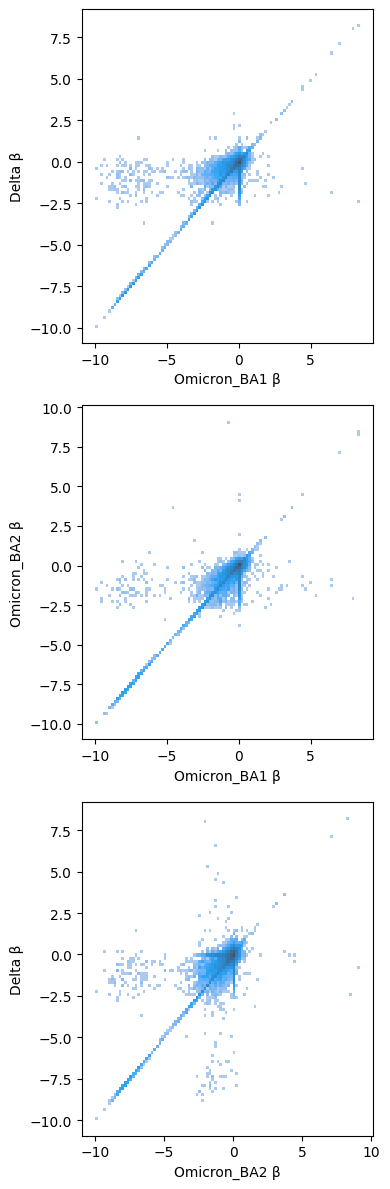

In [21]:
import matplotlib as mpl

plt.figure(figsize=(4, 12))

plt.subplot(311)
ax = sns.histplot(x=model.φ["Omicron_BA1"].β, y=model.φ["Delta"].β, bins=100, norm=mpl.colors.LogNorm(), vmin=None, vmax=None)
# plt.axvline(0, color="black", linestyle="--", lw=1, zorder=0)
# plt.axhline(0, color="black", linestyle="--", lw=1, zorder=0)
plt.xlabel("Omicron_BA1 β")
plt.ylabel("Delta β")

plt.subplot(312)
ax = sns.histplot(x=model.φ["Omicron_BA1"].β, y=model.φ["Omicron_BA2"].β, bins=100, norm=mpl.colors.LogNorm(), vmin=None, vmax=None)
# plt.axvline(0, color="black", linestyle="--", lw=1, zorder=0)
# plt.axhline(0, color="black", linestyle="--", lw=1, zorder=0)
plt.xlabel("Omicron_BA1 β")
plt.ylabel("Omicron_BA2 β")

plt.subplot(313)
ax = sns.histplot(x=model.φ["Omicron_BA2"].β, y=model.φ["Delta"].β, bins=100, norm=mpl.colors.LogNorm(), vmin=None, vmax=None)
# plt.axvline(0, color="black", linestyle="--", lw=1, zorder=0)
# plt.axhline(0, color="black", linestyle="--", lw=1, zorder=0)
plt.xlabel("Omicron_BA2 β")
plt.ylabel("Delta β")


plt.tight_layout()
plt.show()

In [22]:
model.α

{'Delta': Array(4.18804097, dtype=float64),
 'Omicron_BA1': Array(5.01897795, dtype=float64),
 'Omicron_BA2': Array(5.25784737, dtype=float64)}

Distribution of $\beta$

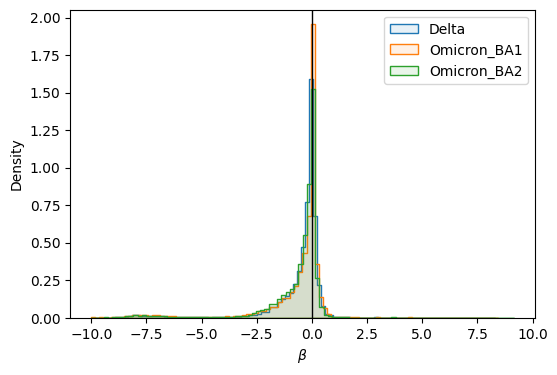

In [24]:
plt.figure(figsize=(6, 4))
for d in model.φ:
    sns.histplot(x=model.φ[d].β, label=d, bins=100, element="step", fill=True, alpha=0.1, stat="density")
plt.axvline(0, color="black", linestyle="-", lw=1)
plt.xlabel(r"$\beta$")
plt.legend()
plt.show()

Compile parameters into dataframe

In [43]:
mutations_df = multidms_data.mutations_df
mutations_df.head()

,mutation,wts,sites,muts,times_seen_Delta,times_seen_Omicron_BA1,times_seen_Omicron_BA2
0,M1F,M,1,F,2,0,0
1,M1I,M,1,I,3,1,5
2,M1K,M,1,K,3,0,0
3,M1L,M,1,L,4,0,0
4,M1N,M,1,N,1,0,0


In [44]:
for d in multidms_data.conditions:
    # add betas to mut dataframe
    mutations_df[f"beta_{d}"] = model.φ[d].β
    # add shifts to mut dataframe
    mutations_df[f"shift_{d}"] = model.φ[d].β - model.φ[multidms_data.reference].β

mutations_df.to_csv(f"{output_dir}/mutations_df.csv", index=False)
mutations_df.head()

,mutation,wts,sites,muts,times_seen_Delta,times_seen_Omicron_BA1,times_seen_Omicron_BA2,beta_Delta,shift_Delta,beta_Omicron_BA1,shift_Omicron_BA1,beta_Omicron_BA2,shift_Omicron_BA2
0,M1F,M,1,F,2,0,0,-1.561681,-1.561681,0.000000,0.0,0.000000,0.000000
1,M1I,M,1,I,3,1,5,-1.266073,1.148338,-2.414411,0.0,-0.939199,1.475212
2,M1K,M,1,K,3,0,0,-1.129681,-1.129681,0.000000,0.0,0.000000,0.000000
3,M1L,M,1,L,4,0,0,-1.420109,-1.420109,0.000000,0.0,0.000000,0.000000
4,M1N,M,1,N,1,0,0,-1.566437,-1.566437,0.000000,0.0,0.000000,0.000000


In [45]:
! tree

zsh:1: command not found: tree


/Users/wsdewitt/miniconda3/envs/multidms/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [36]:
import pandas as pd
import numpy as np
mut_df_combined = pd.DataFrame()
for rep in [1,2]:
    mut_df_combined = pd.concat(
        [
            mut_df_combined,
            pd.read_csv(f"papermill_results/fusionreg=1e-05--replicate={rep}/mutations_df.csv").assign(replicate=rep)
        ]
    )
mut_df_combined

FileNotFoundError: [Errno 2] No such file or directory: 'papermill_results/fusionreg=1e-05--replicate=1/mutations_df.csv'

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
conditions = ["Delta", "Omicron_BA1", "Omicron_BA2"]

In [ ]:
mut_shifts = mut_df_combined.melt(
    id_vars=["mutation", "replicate"],
    value_vars=[f"shift_{d}" for d in conditions],
    var_name="condition",
    value_name="shift",
)

In [ ]:
mut_shifts.info()

In [ ]:
fig, ax = plt.subplots(1,3)
for i, condition in enumerate(conditions):
    sns.histplot(data=mut_shifts.query(f"condition == 'shift_{condition}'"), x="shift", ax=ax[i], bins=100, element="step", fill=True, alpha=0.1, stat="density")
    ax[i].set_title(condition)
plt.tight_layout()
plt.show()

In [ ]:
condition

In [ ]:
mut_shifts.query("(condition==@condition) & (replicate == 2)")["shift"]

In [ ]:
mut_shifts_pivot = mut_shifts.pivot_table(index="mutation", columns=["condition", "replicate"], values="shift")
mut_shifts_pivot[condition][1].values

In [ ]:
# now compare replicate shifts with scatterplot
mut_shifts["condition"] = mut_shifts["condition"].str.replace("shift_", "")
fig, ax = plt.subplots(1,3, figsize=(12, 4))
for i, condition in enumerate(conditions):
    sns.scatterplot(
        data = mut_shifts_pivot[condition],
        x=1, 
        y=2,
        ax=ax[i],
        alpha=0.1,
        s=20
    )
    ax[i].set_title(condition),
    ax[i].set_xlim(-2, 2)
    ax[i].set_ylim(-2, 2)
plt.tight_layout()
plt.show()